## HW10 - Bagging & Boosting
Katie Corcoran

### Random Forest Regression

#### 0. Load the data

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
rand_state = 1000

df = pd.read_csv('bikeshare.csv')
df.drop(['dteday'], axis=1, inplace=True)
df.head()

,season,yr,mnth,hr,holiday,weekday,notbizday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,0,6,1,1,-1.334609,0.947345,-1.553844,16
1,1,0,1,1,0,6,1,1,-1.438475,0.895513,-1.553844,40
2,1,0,1,2,0,6,1,1,-1.438475,0.895513,-1.553844,32
3,1,0,1,3,0,6,1,1,-1.334609,0.636351,-1.553844,13
4,1,0,1,4,0,6,1,1,-1.334609,0.636351,-1.553844,1


#### 1. Split into train and test

In [47]:
target = df['cnt']
X = df.drop('cnt', axis=1, inplace=False)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=rand_state)

#### 2. Perform regression

In [48]:
from sklearn.ensemble import RandomForestRegressor

RF_regression = RandomForestRegressor(random_state=rand_state)
RF_regression.fit(X_train, y_train)

RandomForestRegressor(random_state=1000)

In [49]:
y_hat = RF_regression.predict(X_test)

In [50]:
predictions = pd.DataFrame({'y_test':y_test, 'y_hat':y_hat})
predictions.head()

,y_test,y_hat
4495,26,21.38
4418,47,64.21
7141,11,4.91
14765,205,199.84
16541,65,80.55


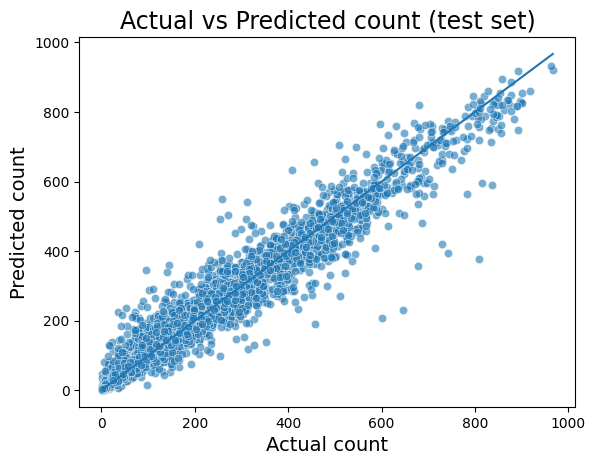

In [51]:
sns.scatterplot(x=y_test, y=y_hat, alpha=0.6)
sns.lineplot(x=y_test, y=y_test)

plt.xlabel('Actual count', fontsize=14)
plt.ylabel('Predicted count', fontsize=14)
plt.title('Actual vs Predicted count (test set)', fontsize=17)
plt.show()

I'm relatively satisfied with this plot. The predictions seem to follow the trend line pretty well, except for some predictions around 600-800 that are a bit further from the line.

In [52]:
R2 = np.round(RF_regression.score(X_test, y_test), 4)
print('R2: %.4f' % R2)

R2: 0.9488


In [16]:
MSE_test = round(np.mean(np.square(y_test - y_hat)), 2)
RMSE_test = round(np.sqrt(MSE_test), 2)
print('RMSE_test: %.2f' % RMSE_test)

RMSE_test: 41.82


#### 3. Tune the parameters

In [54]:
my_param_grid = {'n_estimators':[100,200], 'max_features':['log2','sqrt'], 'max_depth':[10,None]}

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=RandomForestRegressor(random_state=rand_state, n_jobs=-1), param_grid=my_param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..max_depth=10, max_features=log2, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=10, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=10, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=10, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=10, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=10, max_features=log2, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=10, max_features=log2, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=10, max_features=log2, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=10, max_features=log2, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=10, max_features=log2, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=10, max_features=sqrt, n_est

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_jobs=-1, random_state=1000),
             param_grid={'max_depth': [10, None],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [100, 200]},
             verbose=2)

In [55]:
grid.best_params_

{'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}

In [56]:
R2 = np.round(grid.score(X_test, y_test), 4)
print('R2 Optimized: %.4f' % R2)

R2 Optimized: 0.9047


I was not able to improve model performance with these parameters, which tells us that a random forest model does not perform better than bagging in this case. The model is using a bushy tree because it chose a max_depth of None, which means there are no restrictions on how big the tree can be.

#### 4. Cross validation and OOB

In [35]:
from sklearn.model_selection import cross_val_score

R2 = cross_val_score(estimator=RandomForestRegressor(random_state=rand_state), X=X_train, y=y_train, cv=5, scoring='r2')
R2_CV = round(np.mean(R2),4)
print('R2_CV: %.4f' % R2_CV)

R2_CV: 0.9359


In [36]:
RF_oob = RandomForestRegressor(random_state=rand_state, oob_score=True)
RF_oob.fit(X_train, y_train)
print('OOB Score: %.4f' % RF_oob.oob_score_)

OOB Score: 0.9390


Both the cross validated R2 and OOB R2 are pretty close to our actual R2 of 0.9488. The OOB estimate is slightly more accurate than the cross validated estimate.

#### 5. Feature importance

In [39]:
feature_importance_df = pd.DataFrame({'Features': RF_regression.feature_names_in_, 'Feature_importance': RF_regression.feature_importances_}).sort_values(by='Feature_importance')
feature_importance_df

,Features,Feature_importance
4,holiday,0.002778
10,windspeed,0.011502
5,weekday,0.015214
2,mnth,0.016581
7,weathersit,0.018911
0,season,0.021032
9,hum,0.031827
6,notbizday,0.058324
1,yr,0.078848
8,temp,0.135691


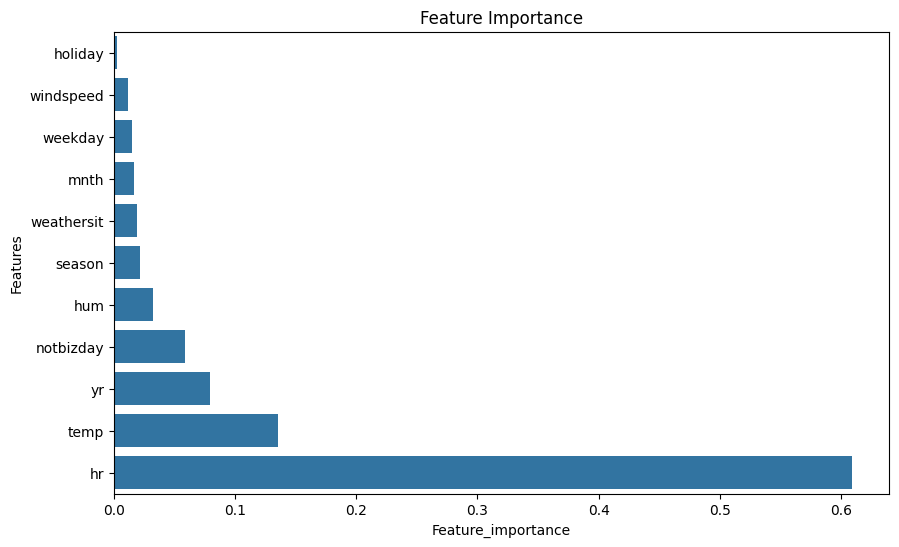

In [40]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(y='Features', x='Feature_importance', data=feature_importance_df)
plt.show()

In [42]:
import statsmodels.formula.api as smf
reg = smf.ols(formula= "cnt ~ holiday + windspeed + weekday + mnth + weathersit + season + hum + notbizday + yr + temp + hr", data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     999.9
Date:                Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:43:07   Log-Likelihood:            -1.1078e+05
No. Observations:               17379   AIC:                         2.216e+05
Df Residuals:                   17367   BIC:                         2.217e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.7741      4.795      2.456      0.014       2.376      21.172
holiday      -23.0244      6.697     -3.438      0.001     -36.151      -9.897
windspeed      3.6249      1.150      3.152      0.002       1.371       5.879
weekday        1.7464      0.541      3.230      0.001       0.687       2.806
mnth          -0.0497      0.568     -0.088      0.930      -1.162       1.063
weathersit    -3.9086      1.904     -2.052      0.040      -7.641      -0.176
season        20.1942      1.820     11.098      0.000      16.628      23.761
hum          -37.8294      1.328    -28.481      0.000     -40.433     -35.226
notbizday     -3.8361      2.398     -1.600      0.110      -8.536       0.864
yr            81.0405      2.166     37.409      0.000      76.794      85.287
temp          54.4771      1.163     46.860      0.000      52.198      56.756
hr             7.7054      0.165     46.716      0.000       7.382       8.029
==============================================================================
Omnibus:                     3429.293   Durbin-Watson:                   0.552
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6680.177
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       4.856   Cond. No.                         95.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notbizday was the 4th most important feature in RF but isn't statistically significant in linear regression. Month is also not significant in linear regression, but month wasn't one of the most important features in RF either. Notbizday may not be as significant in linear regression because of interactions between similar data, such as weekday or holiday, that aren't being captured in the linear model but are in the RF model.

### Random Forest Classification

#### 1. Overload variable

In [4]:
df['overload'] = np.where(df['cnt']>500, 1, 0)
target = df['overload']
pd.crosstab(target, target, normalize='all')*100

overload,0,1
overload,,
0,92.640543,0.000000
1,0.000000,7.359457


The overload variable is highly imbalanced, with roughly 92% of observations being false.

#### 2. Split into train and test

In [30]:
target = df['overload']
X = df.drop(['cnt', 'overload'], axis=1, inplace=False)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=rand_state)

#### 3. Random Forest Classification

In [31]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier = RandomForestClassifier(random_state=rand_state)
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=1000)

In [32]:
y_hat = RF_classifier.predict(X_test)
y_hat_probs = RF_classifier.predict_proba(X_test)[:,1]

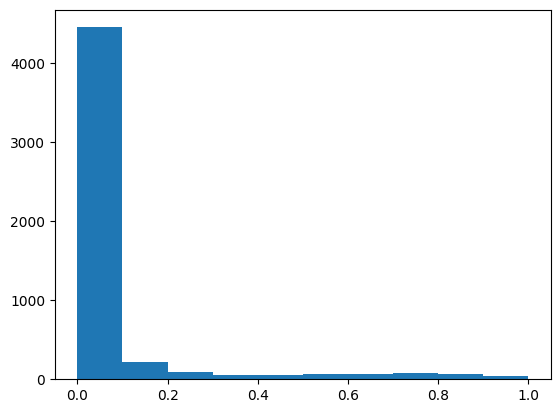

In [8]:
plt.hist(y_hat_probs)
plt.show()

There is no threshold where the model will always predict negative or positive, but the predicted probabilities for overload are mostly very low, between roughly 0-10%.

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

[[4784   35]
 [ 111  284]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4819
           1       0.89      0.72      0.80       395

    accuracy                           0.97      5214
   macro avg       0.93      0.86      0.89      5214
weighted avg       0.97      0.97      0.97      5214



**Accuracy:** An accuracy of 97% means that this model is classifying overload correctly 97% of the time.\
**Precision:** The precision of 89% means that of all predicted overloads, 89% were correct.\
**Recall:** The recall of 72% means that the model identifies 72% of actual overloads.\
**F1-score:** The f1 score is the harmonic mean of precision and recall. Precision is higher, but is being dragged down by a low recall.\
**Confusion Matrix:** The confusion matrix tells us how many true and false negatives and true and false positives were predicted. In this case we have a relatively high number of negatives with 111 (predicting no overload when there was overload), and a few false postives at 35 (predicting overload when there was no overload).

No, I do not trust the accuracy of the model because of the imbalanced target variable.

#### 4. Tuning the hyperparameters

In [10]:
my_param_grid = {'n_estimators':[100,200], 'criterion': ['gini','entropy'], 'max_features':['log2','sqrt'], 'max_depth':[10,None]}

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=rand_state), param_grid=my_param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total ti

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1000),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, None],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [100, 200]},
             verbose=2)

In [13]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'log2',
 'n_estimators': 200}

In [14]:
y_hat_optimized = grid.predict(X_test)
print(confusion_matrix(y_test, y_hat_optimized))
print(classification_report(y_test, y_hat_optimized))

[[4780   39]
 [ 104  291]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4819
           1       0.88      0.74      0.80       395

    accuracy                           0.97      5214
   macro avg       0.93      0.86      0.89      5214
weighted avg       0.97      0.97      0.97      5214



This model performs roughly the same as the intial model. The false negatives went down by a bit so recall went up, but the false positives went up, causing precision to go down, so the f1 score stayed the same overall. Accuracy is also the same as the previous model. This model is using a bushy tree because it chose a max depth of None, which does not limit the depth of the tree.

#### 5. Cross validation and OOB

In [42]:
from sklearn.model_selection import cross_val_score

accuracy = cross_val_score(estimator=RandomForestClassifier(random_state=rand_state), X=X_train, y=y_train, cv=5, scoring='accuracy')
accuracy_CV = round(np.mean(accuracy),4)
print('Accuracy CV: %.4f' % accuracy_CV)

Accuracy CV: 0.9725


In [16]:
RF_oob = RandomForestClassifier(random_state=rand_state, oob_score=True)
RF_oob.fit(X_train, y_train)
print('OOB Score: %.4f' % RF_oob.oob_score_)

OOB Score: 0.9721


Both the cross validated accuracy and the OOB score predict around 97% accuracy, which is equal to the actual performance in the test set.

#### 6. Imbalanced data

In [44]:
RF_balanced = RandomForestClassifier(random_state=rand_state, class_weight='balanced')
y_hat_balanced = RF_balanced.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, y_hat_balanced))
print(classification_report(y_test, y_hat_balanced))

[[4785   34]
 [ 107  288]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4819
           1       0.89      0.73      0.80       395

    accuracy                           0.97      5214
   macro avg       0.94      0.86      0.89      5214
weighted avg       0.97      0.97      0.97      5214



The recall went up slightly, which makes sense because the balanced weighting gives more importance to the minority class, so the model gets better at predicting overloads.

#### 7. ROC Curve

No Skill : ROC AUC=0.500
Random Forest : ROC AUC=0.984


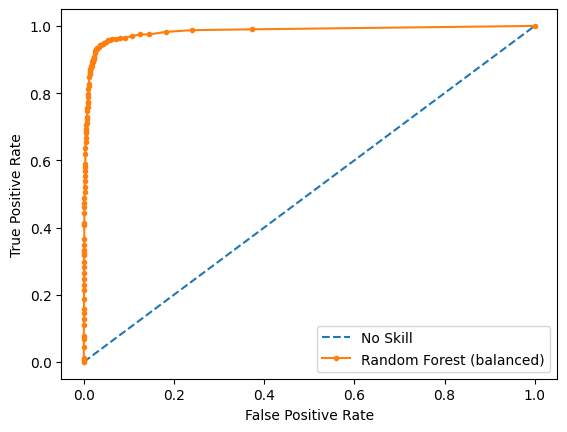

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

ns_probs = [0 for i in range(len(y_test))]
lr_probs = RF_balanced.predict_proba(X_test)[:,1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill : ROC AUC=%.3f' % (ns_auc))
print('Random Forest : ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest (balanced)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

I trust the AUC a bit more now that we're looking at a balanced model, however, because the target variable is so highly imbalanced, I'm worried the AUC may still be inflated.

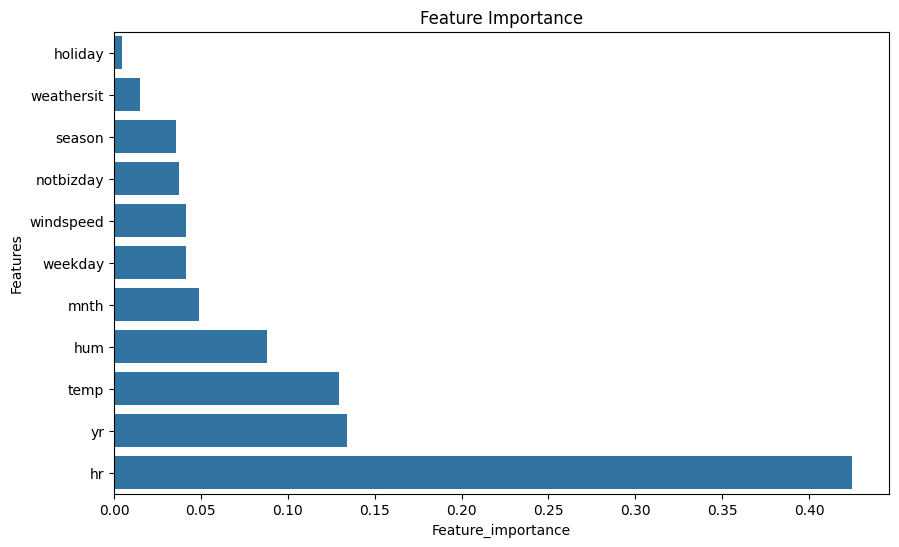

In [20]:
feature_importance_df = pd.DataFrame({'Features': RF_balanced.feature_names_in_ , 'Feature_importance':RF_balanced.feature_importances_}).sort_values(by=['Feature_importance'])
feature_importance_df
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(y='Features', x='Feature_importance', data=feature_importance_df)
plt.show()

The top 5 most important features are hour, year, temperature, humidity, and month. This makes sense because I would expect more people to rent bikes at certain times of day, certain times of year (likely during the Summer), and when the weather is nicer.

### Boosting Classification

In [34]:
%%time
RF_classifier = RandomForestClassifier(random_state=rand_state)
RF_classifier.fit(X_train, y_train)

CPU times: user 338 ms, sys: 15.5 ms, total: 354 ms
Wall time: 359 ms


RandomForestClassifier(random_state=1000)

In [36]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [40]:
%%time
AdB_classifier = AdaBoostClassifier(random_state=rand_state)
AdB_classifier.fit(X_train, y_train)

CPU times: user 157 ms, sys: 10.1 ms, total: 167 ms
Wall time: 169 ms


AdaBoostClassifier(random_state=1000)

In [38]:
%%time
GBM_classifier = GradientBoostingClassifier(random_state=rand_state)
GBM_classifier.fit(X_train, y_train)

CPU times: user 556 ms, sys: 10.6 ms, total: 567 ms
Wall time: 599 ms


GradientBoostingClassifier(random_state=1000)

In [39]:
%%time
XGB_classifier = XGBClassifier(random_state=rand_state)
XGB_classifier.fit(X_train, y_train)

CPU times: user 286 ms, sys: 106 ms, total: 392 ms
Wall time: 103 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1000, ...)

In [ ]:
y_hat_AdB = AdB_classifier.predict(X_test)
y_hat_GBM = GBM_classifier.predict(X_test)
y_hat_XGB = XGB_classifier.predict(X_test)

In [33]:
from sklearn.metrics import f1_score
print('RF  f1 = {}'.format(f1_score(y_test, y_hat)))
print('AdB f1 = {}'.format(f1_score(y_test, y_hat_AdB)))
print('GBM f1 = {}'.format(f1_score(y_test, y_hat_GBM)))
print('XGB f1 = {}'.format(f1_score(y_test, y_hat_XGB)))

RF  f1 = 0.7955182072829131
AdB f1 = 0.6033182503770739
GBM f1 = 0.7780979827089337
XGB f1 = 0.8616187989556136


Execution Speed:
1. AdaBoost      : 167ms
2. Random Forest : 354ms
3. XGBoost       : 392ms
4. GBM           : 567ms

Performance:
1. XGB: 0.86
2. RF: 0.80
3. GBM: 0.78
4. AdB: 0.60

Although XGBoost took longer than AdaBoost, AdaBoost performed relatively poorly. XGBoost's execution was roughly equal to Random Forest while performing better with an f1 score of 0.86, so XGBoost is the overall winner.